# Stripping Column Anomaly Detection Autoencoder

El Stripping consiste en un proceso físico de separación, en donde uno o más componentes son removidos de un flujo, líquido o gaseoso, mediante la inyección de otro fluido, usualmente a contraflujo.

En esta tarea trabajarán sobre el caso de estudio de una columna de Stripping de una planta de extracción de gas natural, la cual está diseñada para remover, mediante la inyección de Amina, el exceso de CO2 en el gas natural. Lo particular de este sistema es que, cuando los sensores detectan un incremento en la concentración de CO2 por sobre el umbral nominal, se activa una alarma para indicar que la instalación presenta un funcionamiento anómalo.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_04/bin/anomalies_plot.png" height="400">

Así, el propósito de esta tarea es desarrollar un detector de anomalías en el funcionamiento de la columna de Stripping, mediante autoencoders. Similar al caso estudiado con los datos de CMAPSS, en el dataset `stripper_dataset.npz` cuentan con el registro temporal de `10 sensores`, organizados en ventanas temporales de `18 timesteps`, i.e el dataset es de la forma `(n_samples, n_timesteps, n_features)`. La tasa de muestreo del dataset es de `20min` por lo que cada ventana comprende un periodo de `6hrs` de registro.

Adicionalmente, los conjuntos han sido previamente normalizados y separados en conjuntos de entrenamiento, validación, y testing `(X_train, X_val, X_test)`. Cada uno de estos conjuntos, por supuesto, cuentan con sus etiquetas `(Y_train, Y_val, Y_test)` las cuales contienen el estado de alarma de la columna de Stripping `2hrs` después de su ventana correspondiente, donde `1` indica estado de alarma, mientras que `0` indica un funcionamiento nominal en la planta.

El dataset `stripper_dataset.npz` se encontrará disponible en el material docente del curso.

## Formato de Entrega

Los entregables de esta tarea son los siguientes.
- Jupyter Notebook (.ipynb): Todo el procesamiento de la tarea debe estar contenido en un único Notebook. Considere este archivo como un informe de metodología donde se reporten todos los pasos y bloques de código utilizados para resolver el problema. **Sea ordenado**; utilice comentarios en su código y bloques de texto para mejorar la legibilidad del Notebook.

- Reporte Resultados (.pdf): Este archivo debe contener los resultados obtenidos en su tarea, junto con un análisis correspondiente. Considere este documento como la sección de Resultados y Análisis de la tarea. En este sentido, debe mantener un formato de informe estándar.

## 1. Anomaly Detection

Mediante `keras` implementen un `Vanilla Autoencoder` y entrénelo sobre las ventanas temporales `nominales` del conjunto de entrenamiento y validación `(X_train, X_val)`. El objetivo de esto es posteriormente utilizar el error de reconstrucción del `Autoencoder` como un discriminador de anomalías.

Al evaluar su modelo sobre los datos de testing `(X_test)`, deberán definir un umbral de discrimación o `threshold` que, a partir del error de recontrucción de las ventanas temporales, segementará los datos anómalos de los nominales. De este modo, podrán realizar una clasificación binaria de los datos para generar las etiquetas `Y_pred`, que compararán con las etiquetas originales `Y_test`.

El detector de anomalías debe priorizar la disminución de `falsos negativos`, es decir, cuando la planta presenta un estado anómalo en funcionamiento, pero el detector lo clasifica como nominal. En este sentido, no debe presentar más de `30 FN` en el conjunto de testing. Una vez hayan configurado su detector de anomalías, reporten:

- Gráfico de función de pérdida durante el entrenamiento del `Autoencoder`. Una opción es utilizar como set de validación datos que presenten un estado de alarma, para así observar directamente la divergencia en el error de reconstrucción entre ambos conjuntos. Puede utilizar la función `plot_loss_function` presente en el GitHub del curso.
- Gráfico que muestre la discriminación entre datos `nominales` y `anómalos` en función del umbral de su detector de anomalías. Pueden usar el gráfico de este enunciado como referencia.
- Matriz de confusión que compare la clasificación de su detector de anomalías `(Y_pred)` con las etiquetas originales del conjuntos de testing `(Y_test)`. Puede utilizar la función `plot_confusion_matrix` presente en el GitHub del curso.
- Gráfico ROC de la clasificación de su detector de anomalías sobre el conjunto de testing. Recuerden que mientras mayor sea la `AUC` (Area Under Curve) mejor será su discriminador de anomalías.

## Desarrollo

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
data = np.load('/content/drive/MyDrive/stripper_dataset.npz')
for k in data.keys():
    print(k, data[k].shape)

x_train (4256, 18, 10)
y_train (4256, 1)
x_valid (752, 18, 10)
y_valid (752, 1)
x_test (884, 18, 10)
y_test (884, 1)


In [5]:
def processData(dataset):

    # sacar conjunto X_train
    print('cargar datos')
    X_train = dataset['x_train']
    Y_train = dataset['y_train']
    X_val = dataset['x_valid']
    Y_val = dataset['y_valid']
    X_test = dataset['x_test']
    Y_test = dataset['y_test']

    n_features = X_train.shape[2]

    print('explorar distribuciones de datos de entrenamiento')
    fig, axs = plt.subplots(3, n_features, figsize=(28,4),
                            constrained_layout=True)

    fig.suptitle('sensors histogram', fontsize=24)
    axs[0,0].set_ylabel('X_train')
    axs[1,0].set_ylabel('X_val')
    axs[2,0].set_ylabel('X_test')
    for sensor in range(n_features):
        axs[0,sensor].hist(X_train[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
        axs[0,sensor].set_title(sensor)
        axs[1,sensor].hist(X_val[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
        axs[2,sensor].hist(X_test[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
    
    plt.show()

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

cargar datos
explorar distribuciones de datos de entrenamiento


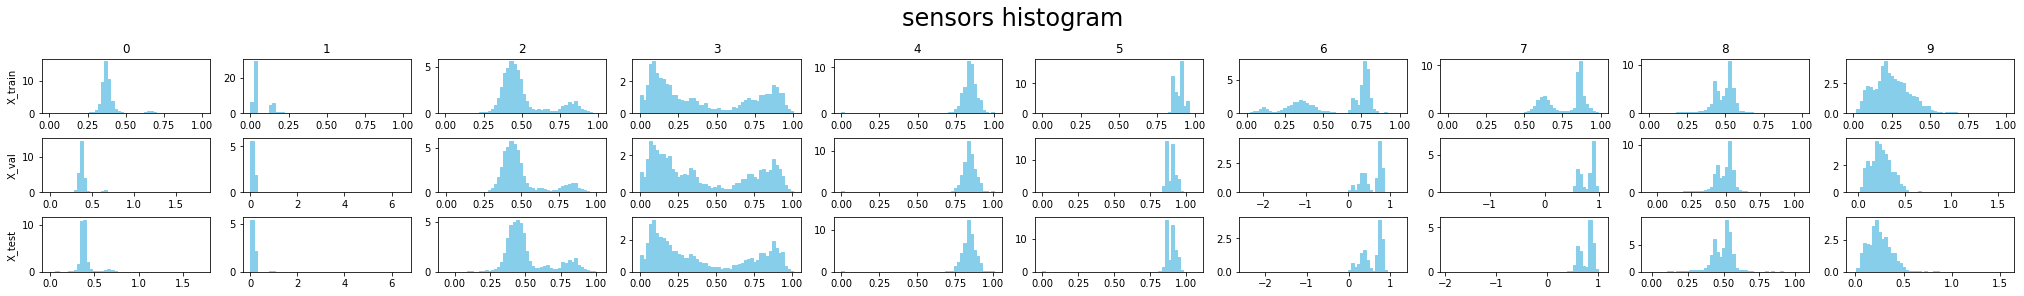

In [6]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = processData(data)

Del análisis anterior, se puede ver que en los datos de validación y de test existen sensores que se salen de los rangos del conjunto de entrenamiento. Esto no debería afectar el entrenamiento de ningún modelo, pero es útil notarlo.

In [7]:
# ----------------------------------------------------------------------------
def plot_loss_function(train_info, figsize=(5,5)):
    """
    -> None
    
    this function plots de evolution of the loss function of the model 
    during the training epochs.
    
    :param train_info:
        training history of the classification model.
        
    """
    # crear figura
    plt.figure(figsize=figsize)
    
    plt.plot(train_info.history['loss'])
    plt.plot(train_info.history['val_loss'])
    
    # caracteristicas del plot
    plt.title('Model loss')
    plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
 
# ----------------------------------------------------------------------------

In [8]:
import keras
from keras.models import Model
from keras.layers import Input

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Reshape

from keras.optimizers import Adam

In [91]:
def train(model, X_train, X_val, epochs):

    print('inicializacion de parametros')
    opt = Adam( learning_rate=1e-3 )

    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    # print sample distribution
    print( 'train split: {:d} samples'.format(X_train.shape[0]) )
    print( '\nvalidation split: {:d} samples'.format(X_val.shape[0]) )
    
    print('realizar rutina de entrenamiento')
    model_history = model.fit(X_train, X_train,
                              batch_size=128, epochs=epochs,
                              validation_data=(X_val, X_val),
                              callbacks=[callback])

    # plot gráfico de función de pérdida
    plot_loss_function(model_history, figsize=(10,4))
    
    return model, model_history

In [137]:
# creacion de modelo
input_dim = ( 18 * 10 )
input_layer = Input( shape=input_dim )

encoder = Dense(units=1800, activation='relu')(input_layer)
encoder = Dense(units=1800, activation='relu')(encoder)
encoder = Dropout(rate=0.1)(encoder)
encoder = Dense(units=1000, activation='relu')(encoder)
encoder = Dense(units=1000, activation='relu')(encoder)
encoder = Dropout(rate=0.1)(encoder)
encoder = Dense(units=700, activation='relu')(encoder)
encoder = Dense(units=700, activation='relu')(encoder)

latent_dim = 500
latent_vector = Dense(units=latent_dim, activation='relu')(encoder)

decoder = Dense(units=700, activation='relu')(latent_vector)
decoder = Dense(units=700, activation='relu')(decoder)
decoder = Dropout(rate=0.1)(decoder)
decoder = Dense(units=1000, activation='relu')(decoder)
decoder = Dense(units=1000, activation='relu')(decoder)
decoder = Dropout(rate=0.1)(decoder)
decoder = Dense(units=1800, activation='relu')(decoder)
decoder = Dense(units=1800, activation='relu')(decoder)

output_layer = Dense(units=18 * 10, activation='linear')(decoder)

autoencoder = Model(input_layer, output_layer)

encoder_model = Model(input_layer, latent_vector)

autoencoder.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 180)]             0         
_________________________________________________________________
dense_198 (Dense)            (None, 1800)              325800    
_________________________________________________________________
dense_199 (Dense)            (None, 1800)              3241800   
_________________________________________________________________
dropout_54 (Dropout)         (None, 1800)              0         
_________________________________________________________________
dense_200 (Dense)            (None, 1000)              1801000   
_________________________________________________________________
dense_201 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dropout_55 (Dropout)         (None, 1000)              0  

In [138]:
X_train_ = X_train.reshape(-1, 18 * 10)
X_val_ = X_val.reshape(-1, 18 * 10)

# seleccionar datos nominales para entrenar
nominales = np.where(Y_train == 1)[0]
alarmas = np.where(Y_train == 0)[0]
print(f'nominales: {np.sum(Y_train_)} {nominales.shape[0]}')
print(f'alarma: {alarmas.shape[0]}')

X_train_ = X_train_[nominales, :]

nominales = np.where(Y_val == 1)[0]
X_val_ = X_val_[nominales, :]


nominales: 3276 3276
alarma: 980


inicializacion de parametros
train split: 3276 samples

validation split: 587 samples
realizar rutina de entrenamiento
Epoch 1/15
26/26 [==============================] - 8s 261ms/step - loss: 1.5495 - mae: 0.7299 - val_loss: 0.3141 - val_mae: 0.4852
Epoch 2/15
26/26 [==============================] - 6s 250ms/step - loss: 0.2300 - mae: 0.3969 - val_loss: 0.0334 - val_mae: 0.1466
Epoch 3/15
26/26 [==============================] - 6s 248ms/step - loss: 0.0234 - mae: 0.1147 - val_loss: 0.0150 - val_mae: 0.0770
Epoch 4/15
26/26 [==============================] - 6s 250ms/step - loss: 0.0142 - mae: 0.0778 - val_loss: 0.0142 - val_mae: 0.0697
Epoch 5/15
26/26 [==============================] - 6s 249ms/step - loss: 0.0140 - mae: 0.0761 - val_loss: 0.0141 - val_mae: 0.0689
Epoch 6/15
26/26 [==============================] - 6s 248ms/step - loss: 0.0140 - mae: 0.0748 - val_loss: 0.0141 - val_mae: 0.0699
Epoch 7/15
26/26 [==============================] - 7s 252ms/step - loss: 0.0140 - mae: 0

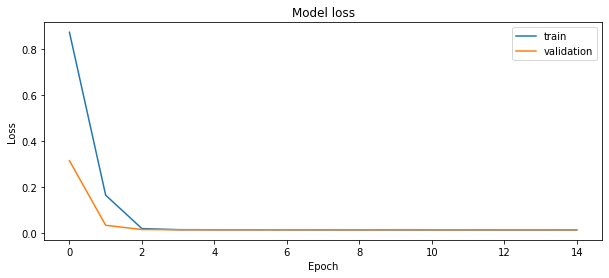

In [139]:
# entrenar modelo sobre datos de operacion nominal
model, model_history = train(autoencoder, X_train_, X_val_, 15)

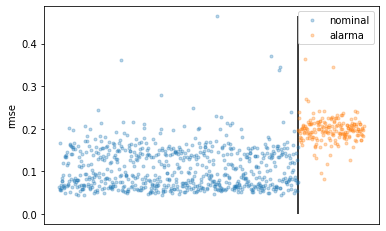

In [291]:
# obtener reconstruccion sobre datos de test
x_pred = model.predict(X_test_)
x_true = X_test_

# calcular rmse
rmse = np.sqrt( np.mean( np.power( x_pred - x_true, 2 ), axis=1 ) )
ejex = np.linspace(0, X_test.shape[0], num=X_test.shape[0], dtype=int)

plt.vlines(ejex[:nominal.shape[0]][-1], 0, np.max(rmse))

nominal = np.where(Y_test == 1)[0]
alarma = np.where(Y_test == 0)[0]

plt.plot(ejex[:nominal.shape[0]], rmse[nominal], ls='', marker='.',
         alpha=0.3, label='nominal')
plt.plot(ejex[-alarma.shape[0]:], rmse[alarma], ls='', marker='.',
         alpha=0.3, label='alarma')


plt.legend()
plt.ylabel('rmse')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

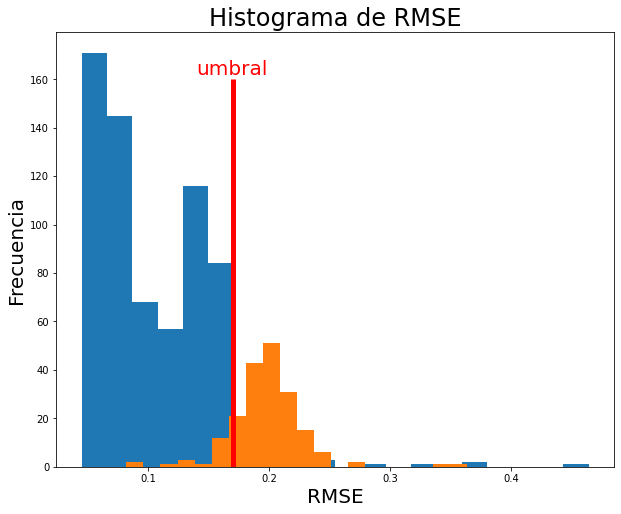

In [305]:
plt.figure(figsize=(10,8))
plt.hist(rmse[nominal], bins=20, label='nominal')
plt.hist(rmse[alarma], bins=20, label='alarma')
plt.xlabel('RMSE', fontsize=20)
plt.ylabel('Frecuencia', fontsize=20)
plt.title('Histograma de RMSE', fontsize=24)
plt.vlines(0.17, 0, 160, color='r', lw=5)
plt.text(0.14, 162, 'umbral', color='r', fontsize=20)
plt.show()

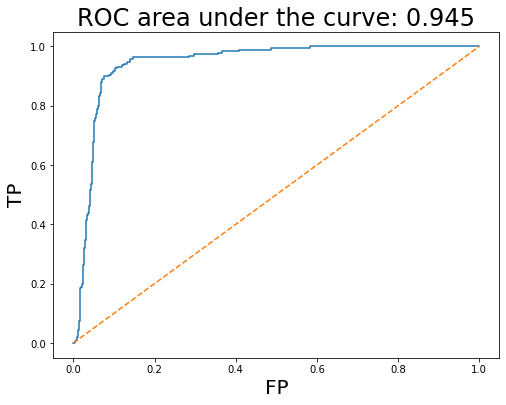

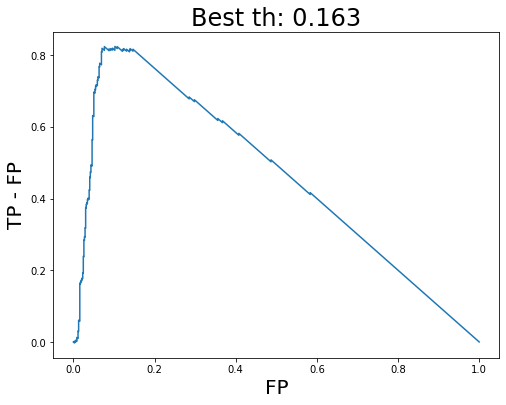

In [309]:
from sklearn.metrics import roc_curve, auc

# crear curva ROC
# se dan vuelta los tpr con fpr ya que
# los labels 0 corresponde a alarma (positivo)
fpr, tpr, ths = roc_curve(1 - Y_test.flatten(), rmse)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls='--')
plt.title(f'ROC area under the curve: {roc_auc:.3f}', fontsize=24)
plt.ylabel('TP', fontsize=20)
plt.xlabel('FP', fontsize=20)
plt.show()


best_th = ths[np.argmax(tpr - fpr)]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr - fpr)
plt.title(f'Best th: {best_th:.3f}', fontsize=24)
plt.ylabel('TP - FP', fontsize=20)
plt.xlabel('FP', fontsize=20)
plt.show()



In [277]:

from matplotlib import cm

from sklearn.metrics import confusion_matrix

# ----------------------------------------------------------------------------
def plot_confusion_matrix(Y_true, Y_pred, target_names,
                          title='Confusion matrix',
                          cmap=None, normalize=False,
                          figsize=(5,5)):
    
    """
    given the true (Y_true) and the predicted (Y_pred) labels,
    makes the confusion matrix.
    
    :param np.array Y_true:
        the true labels of the data. (no one hot encoding).
    :param np.array Y_pred:
        the predicted labels of the data by the model. (no one hot encoding).
    :param list target_names:
        given classification classes such as [0, 1, 2] the class names,
        for example: ['high', 'medium', 'low'].
    :param str title:
        the text to display at the top of the matrix.
    :param str cmap:
        the gradient of the values displayed from matplotlib.pyplot.cm
        see http://matplotlib.org/examples/color/colormaps_reference.html
        plt.get_cmap('jet') or plt.cm.Blues.
    :param bool normalize:
        if False, plot the raw numbers, if True, plot the proportions.
        
    :reference:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        
    """
    import itertools
    
    cm = confusion_matrix(Y_true, Y_pred)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      verticalalignment="center",
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                      verticalalignment="center",
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [318]:
def plot_confusionMatrix(th):
    #### OPERACION NOMINAL

    nominal = np.where(Y_test == 1)[0]
    rmse_nominal = rmse[nominal]
    ejex = np.linspace(0, nominal.shape[0], num=nominal.shape[0], dtype=int)

    real_nominal = np.where(rmse_nominal < th)[0]
    falsa_alarma = np.where(rmse_nominal > th)[0]


    plt.figure(figsize=(15,10))
    plt.plot(ejex[real_nominal], rmse_nominal[real_nominal], ls='', marker='.', alpha=0.3, label='real nominal', ms=15)
    plt.plot(ejex[falsa_alarma], rmse_nominal[falsa_alarma], ls='', marker='.', alpha=0.3, label='falsa alarma', ms=15)
    plt.text(ejex.mean() * 0.8, rmse_nominal[real_nominal].mean(),
            f'TN: {real_nominal.shape[0]}', fontsize=25)
    plt.text(ejex.mean() * 0.8, rmse_nominal[falsa_alarma].mean(),
            f'FP: {falsa_alarma.shape[0]}', fontsize=25)


    #### OPERACION EN ALARMA

    alarma = np.where(Y_test == 0)[0]
    rmse_alarma = rmse[alarma]
    ejex = nominal.shape[0] + np.linspace(0, alarma.shape[0], num=alarma.shape[0], dtype=int)

    real_alarma = np.where(rmse_alarma > th)[0]
    falsa_nominal = np.where(rmse_alarma < th)[0]


    plt.plot(ejex[real_alarma], rmse_alarma[real_alarma], ls='', marker='.', alpha=0.3, label='real alarma', ms=15)
    plt.plot(ejex[falsa_nominal], rmse_alarma[falsa_nominal], ls='', marker='.', alpha=0.3, label='falsa nominal', ms=15)
    plt.text(ejex.mean() * 0.95, rmse_alarma[real_alarma].mean(),
            f'TP: {real_alarma.shape[0]}', fontsize=25)
    plt.text(ejex.mean() * 0.95, rmse_alarma[falsa_nominal].mean() - 0.05,
            f'FN: {falsa_nominal.shape[0]}', fontsize=25)


    ## GRAFICAR TH
    plt.hlines(th, 0, ejex[-1])
    ## SEPARACION DATOS NOMINALES Y ALARMA
    plt.vlines(nominal.shape[0], 0, rmse.max())

    plt.legend(fontsize=18)
    plt.ylabel('RMSE', fontsize=20)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.show()

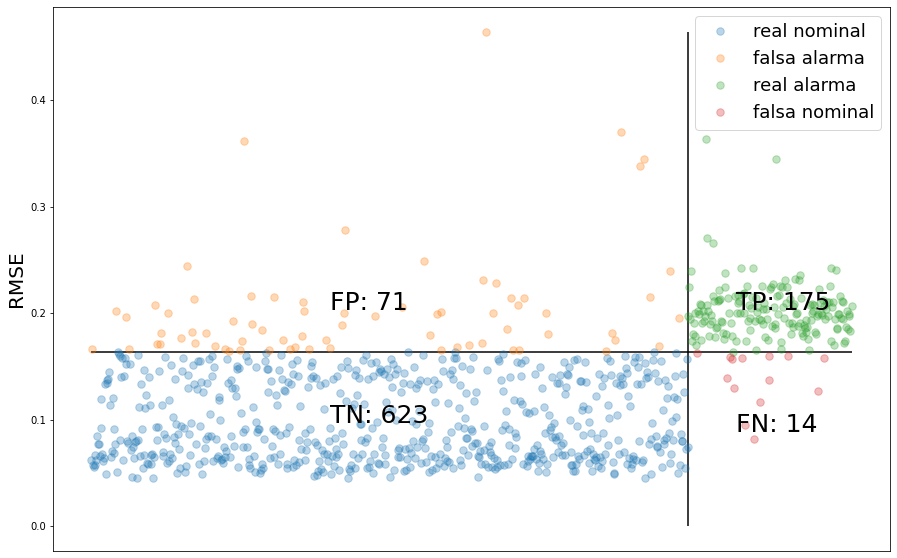

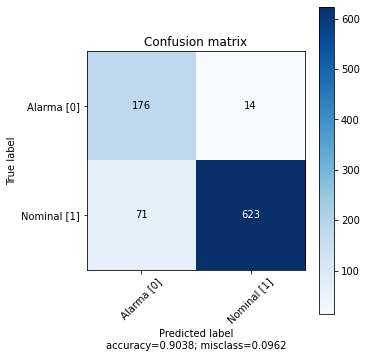

In [319]:
# dibujar rmse y division de ejemplos segun mejor th de separacion para FN = 30
plot_confusionMatrix(best_th)
plot_confusion_matrix(Y_test, rmse < best_th, ['Alarma [0]', 'Nominal [1]'])

In [254]:
# encontrar th para que FN sean 30
nominal = np.where(Y_test == 1)[0]
rmse_nominal = rmse[nominal]

alarma = np.where(Y_test == 0)[0]
rmse_alarma = rmse[alarma]
rate = []

for th in ths:
    real_nominal = np.where(rmse_nominal < th)[0]
    falsa_alarma = np.where(rmse_nominal > th)[0]

    real_alarma = np.where(rmse_alarma > th)[0]
    falsa_nominal = np.where(rmse_alarma < th)[0]

    rate.append(falsa_alarma.shape[0] + falsa_nominal.shape[0])

    if falsa_nominal.shape[0] == 30 or th == best_th:
        print(f'{th:.3f}')
        print(f'FP: {falsa_alarma.shape[0]},TP: {real_alarma.shape[0]}')
        print(f'TN: {real_nominal.shape[0]}, FN: {falsa_nominal.shape[0]}')


0.176
FP: 45,TP: 159
TN: 649, FN: 30
0.175
FP: 47,TP: 160
TN: 646, FN: 30
0.163
FP: 71,TP: 175
TN: 623, FN: 14


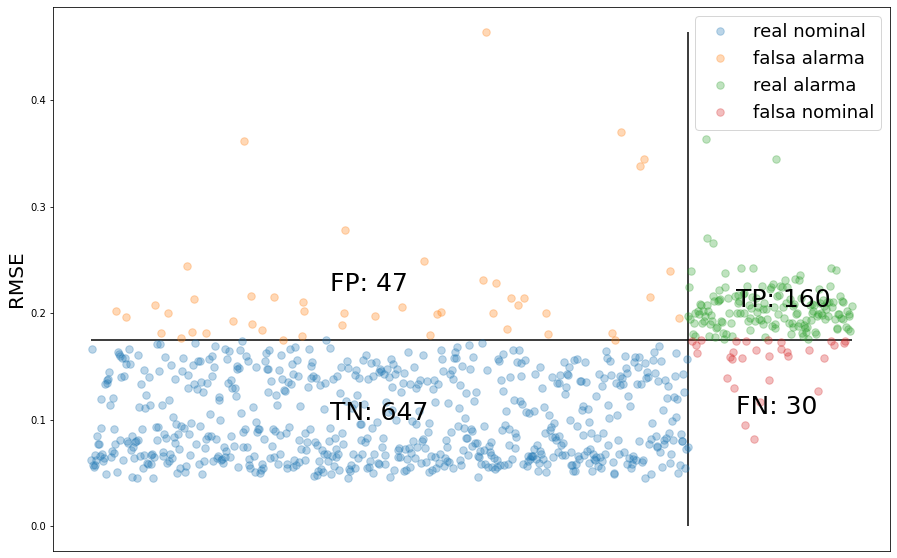

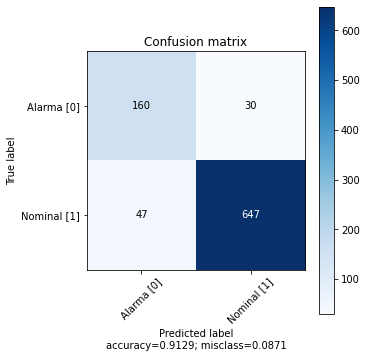

In [320]:
plot_confusionMatrix(0.175)
plot_confusion_matrix(Y_test, rmse < 0.175, ['Alarma [0]', 'Nominal [1]'])


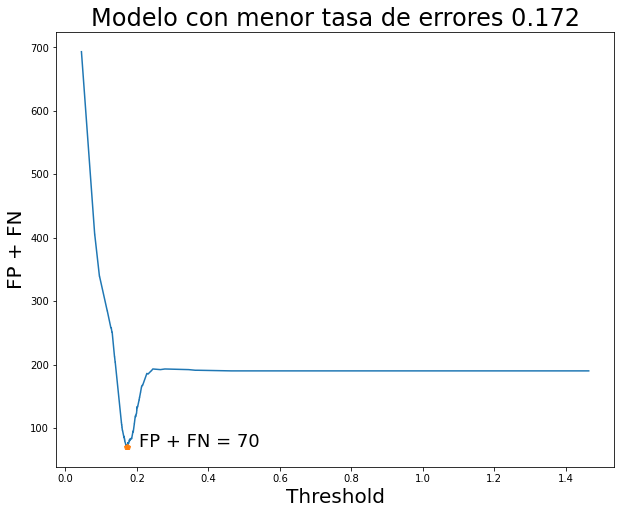

In [276]:
plt.figure(figsize=(10,8))
plt.plot(ths, rate)
plt.title(f'Modelo con menor tasa de errores {ths[np.argmin(rate)]:.3f} sobre conjunto de test', fontsize=24)
plt.ylabel('FP + FN', fontsize=20)
plt.xlabel('Threshold', fontsize=20)
plt.plot(ths[np.argmin(rate)], np.min(rate), marker='p')
plt.text(ths[np.argmin(rate)] * 1.2, np.min(rate),
         f'FP + FN = {np.min(rate)}', fontsize=18)
plt.show()

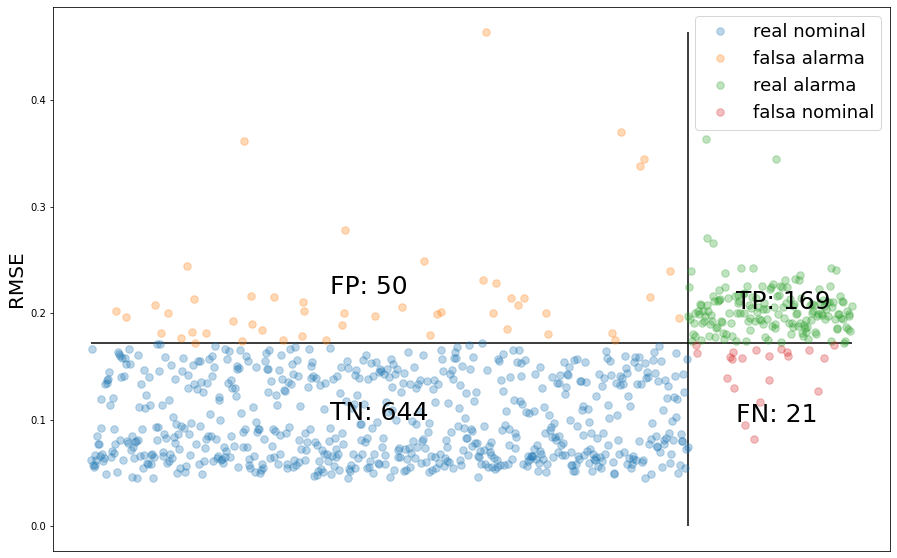

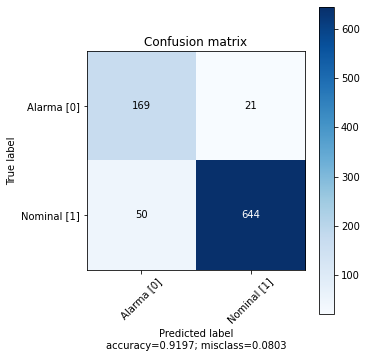

In [321]:
plot_confusionMatrix(0.172)
plot_confusion_matrix(Y_test, rmse < 0.172, ['Alarma [0]', 'Nominal [1]'])
